# Shinkansen Bullet Train — Passenger Satisfaction Prediction

## Mission Statement

The goal of this project is to predict whether a Shinkansen (bullet train) passenger was **satisfied** (1) or **not satisfied** (0) with their overall travel experience, based on travel attributes and post-service survey responses.

## Dataset

Two source datasets per split (train/test):
- **Travel Data** — passenger demographics and trip logistics: Gender, Customer Type, Age, Travel Purpose, Travel Class, Distance, Delays
- **Survey Data** — 14 post-service satisfaction ratings (ordinal, from "Extremely Poor" to "Excellent") plus Seat Class

Training set: **94,379** passengers. Test set: **35,602** passengers.  
Evaluation metric: **Accuracy**.

## Methodology

1. **Data exploration** — understand distributions, missing patterns, feature correlations
2. **Feature engineering** — aggregate survey statistics, delay ratios, missing value indicators, interaction features
3. **Stacking ensemble** — Optuna-tuned LightGBM + XGBoost + CatBoost with weighted average blending
4. **Pseudo-labeling** — use high-confidence test predictions as additional training data, retrain
5. **Seed averaging** — train with multiple random seeds, average predictions for stability

## Previous Results

| Version | Approach | Test Accuracy | Rank |
|---------|----------|---------------|------|
| V1 | Single LightGBM, manual params | 0.9555643 | 3rd |
| V2 | Optuna-tuned stacking ensemble | 0.9574743 | 2nd |
| **V4** | **+ Pseudo-labeling** | **TBD** | **TBD** |

In [2]:
# --- Imports & Configuration ---

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# --- Reproducibility ---
SEED = 42
N_FOLDS = 5
np.random.seed(SEED)

DATA_DIR = '.'

# --- GPU Configuration ---
# Set USE_GPU = False if running on a machine without a CUDA-capable GPU.
# LightGBM stays on CPU (pip build lacks CUDA). XGBoost and CatBoost use GPU.
USE_GPU = True

XGB_DEVICE = {'device': 'cuda'} if USE_GPU else {}
CB_DEVICE = {'task_type': 'GPU'} if USE_GPU else {}

# --- Optimized hyperparameters (from Optuna tuning in V2, 100 trials each) ---
BEST_LGB_PARAMS = {
    'n_estimators': 5000,
    'learning_rate': 0.02006130404098335,
    'max_depth': 10,
    'num_leaves': 82,
    'subsample': 0.6363020221407356,
    'colsample_bytree': 0.6163799680541543,
    'min_child_samples': 14,
    'reg_alpha': 0.4959859942324878,
    'reg_lambda': 0.028694549312225034,
    'random_state': SEED,
    'verbose': -1,
    'n_jobs': -1
}

BEST_XGB_PARAMS = {
    'n_estimators': 5000,
    'learning_rate': 0.02629765461385586,
    'max_depth': 10,
    'subsample': 0.933787944562583,
    'colsample_bytree': 0.8418629840543196,
    'min_child_weight': 2,
    'reg_alpha': 0.015500510498064968,
    'reg_lambda': 0.0024044203758951436,
    'gamma': 0.38915388203943474,
    'random_state': SEED,
    'eval_metric': 'error',
    'verbosity': 0,
    'n_jobs': -1,
    'tree_method': 'hist',
    **XGB_DEVICE
}

BEST_CB_PARAMS = {
    'iterations': 5000,
    'learning_rate': 0.06037233501239291,
    'depth': 8,
    'l2_leaf_reg': 0.24566928171583854,
    'border_count': 68,
    'bagging_temperature': 0.3576537029657124,
    'random_strength': 0.14575253908437555,
    'random_seed': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 100,
    **CB_DEVICE
}

# Stacking weights (optimized via grid search in V2)
STACK_WEIGHTS = (0.25, 0.40, 0.35)  # LGB, XGB, CB

# Pseudo-labeling confidence threshold
PL_CONFIDENCE = 0.95

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

print(f'GPU enabled: {USE_GPU}')
print('Setup complete')

GPU enabled: True
Setup complete


In [3]:
# --- Data Loading & Merging ---

travel_train = pd.read_csv(f'{DATA_DIR}/Traveldata_train_(1).csv')
survey_train = pd.read_csv(f'{DATA_DIR}/Surveydata_train_(1).csv')
travel_test = pd.read_csv(f'{DATA_DIR}/Traveldata_test_(1).csv')
survey_test = pd.read_csv(f'{DATA_DIR}/Surveydata_test_(1).csv')

# Inner join on passenger ID
train = travel_train.merge(survey_train, on='ID', how='inner')
test = travel_test.merge(survey_test, on='ID', how='inner')

target_col = 'Overall_Experience'
y_train = train[target_col].values
test_ids = test['ID'].values

print(f'Training set: {train.shape[0]:,} passengers, {train.shape[1]} columns')
print(f'Test set:     {test.shape[0]:,} passengers, {test.shape[1]} columns')
print(f'\nTarget variable: {target_col}')
print(f'  Satisfied (1):     {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})')
print(f'  Not satisfied (0): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})')

Training set: 94,379 passengers, 25 columns
Test set:     35,602 passengers, 24 columns

Target variable: Overall_Experience
  Satisfied (1):     51,593 (54.7%)
  Not satisfied (0): 42,786 (45.3%)


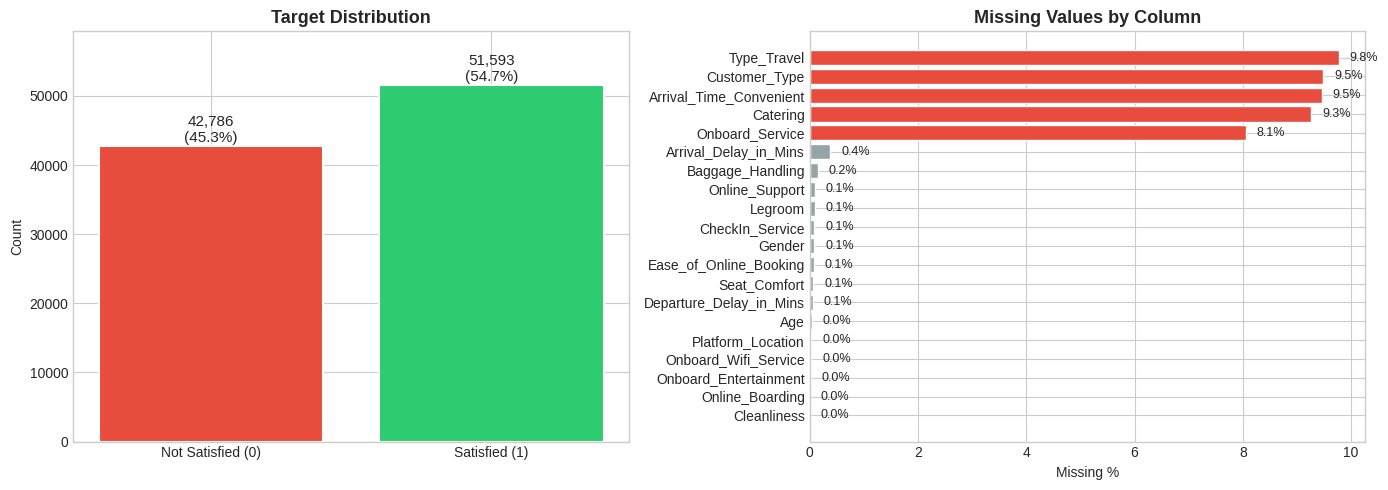

Columns with >5% missing: 5
Columns with any missing:  20


In [4]:
# --- EDA: Target Distribution & Missing Values ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target distribution
ax = axes[0]
counts = pd.Series(y_train).value_counts().sort_index()
bars = ax.bar(['Not Satisfied (0)', 'Satisfied (1)'], counts.values,
              color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=1.5)
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{count:,}\n({count/len(y_train):.1%})', ha='center', fontsize=11)
ax.set_title('Target Distribution', fontsize=13, fontweight='bold')
ax.set_ylabel('Count')
ax.set_ylim(0, max(counts.values) * 1.15)

# Missing values (only columns with missing data)
ax = axes[1]
missing_pct = (train.isnull().sum() / len(train) * 100).sort_values(ascending=True)
missing_pct = missing_pct[missing_pct > 0]
colors = ['#e74c3c' if v > 5 else '#f39c12' if v > 1 else '#95a5a6' for v in missing_pct.values]
ax.barh(missing_pct.index, missing_pct.values, color=colors, edgecolor='white')
ax.set_xlabel('Missing %')
ax.set_title('Missing Values by Column', fontsize=13, fontweight='bold')
for i, (col, pct) in enumerate(missing_pct.items()):
    ax.text(pct + 0.2, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f'Columns with >5% missing: {(missing_pct > 5).sum()}')
print(f'Columns with any missing:  {(missing_pct > 0).sum()}')

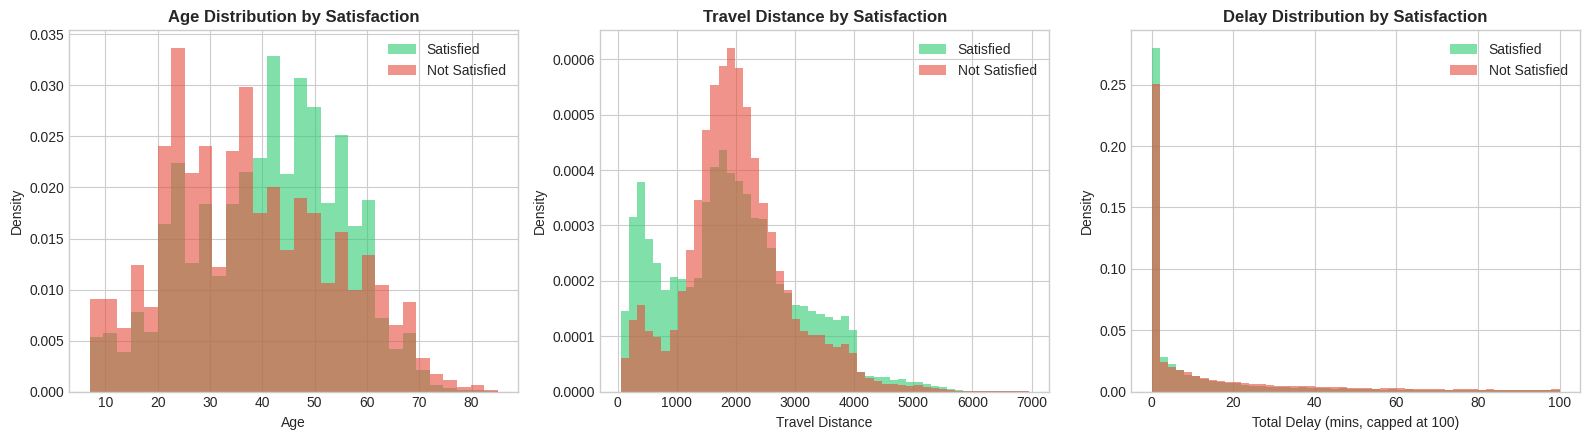

In [5]:
# --- EDA: Feature Distributions ---

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Age distribution by satisfaction
ax = axes[0]
for label, color, name in [(1, '#2ecc71', 'Satisfied'), (0, '#e74c3c', 'Not Satisfied')]:
    ax.hist(train.loc[train[target_col] == label, 'Age'].dropna(),
            bins=30, alpha=0.6, color=color, label=name, density=True)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('Age Distribution by Satisfaction', fontsize=12, fontweight='bold')
ax.legend()

# Travel distance distribution (log scale)
ax = axes[1]
for label, color, name in [(1, '#2ecc71', 'Satisfied'), (0, '#e74c3c', 'Not Satisfied')]:
    data = train.loc[train[target_col] == label, 'Travel_Distance'].dropna()
    ax.hist(data, bins=50, alpha=0.6, color=color, label=name, density=True)
ax.set_xlabel('Travel Distance')
ax.set_ylabel('Density')
ax.set_title('Travel Distance by Satisfaction', fontsize=12, fontweight='bold')
ax.legend()

# Delay distribution
ax = axes[2]
total_delay = train['Departure_Delay_in_Mins'].fillna(0) + train['Arrival_Delay_in_Mins'].fillna(0)
for label, color, name in [(1, '#2ecc71', 'Satisfied'), (0, '#e74c3c', 'Not Satisfied')]:
    data = total_delay[train[target_col] == label]
    ax.hist(data[data <= 100], bins=50, alpha=0.6, color=color, label=name, density=True)
ax.set_xlabel('Total Delay (mins, capped at 100)')
ax.set_ylabel('Density')
ax.set_title('Delay Distribution by Satisfaction', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

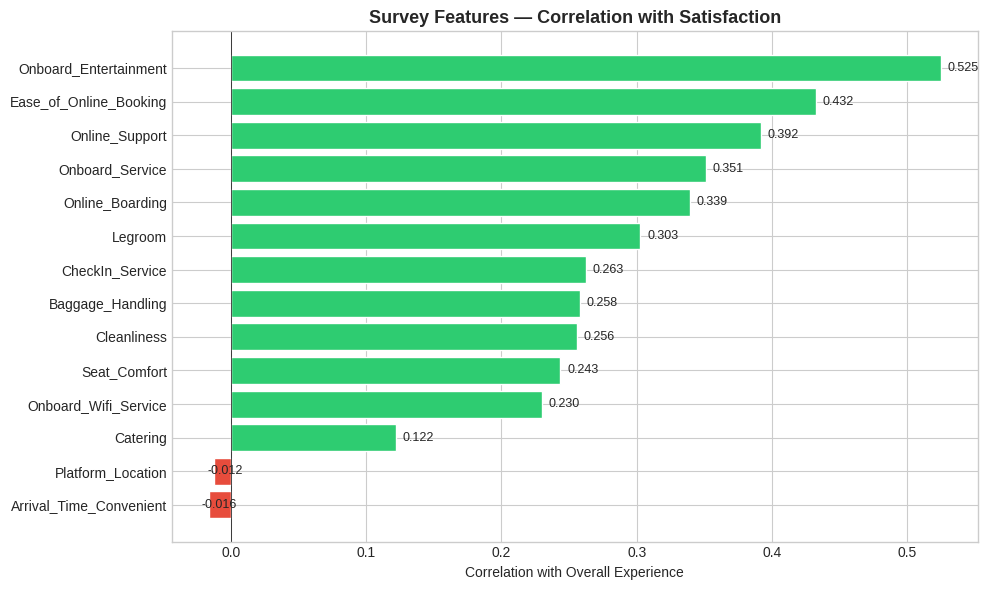

All survey features are positively correlated with satisfaction.
Strongest: Onboard_Entertainment (0.525)
Weakest:   Arrival_Time_Convenient (-0.016)


In [6]:
# --- EDA: Survey Ratings Correlation with Target ---

survey_cols = [
    'Seat_Comfort', 'Arrival_Time_Convenient', 'Catering',
    'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
    'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding'
]

# Encode survey columns temporarily for correlation
ordinal_map = {
    'Extremely Poor': 0, 'Poor': 1, 'Needs Improvement': 2,
    'Acceptable': 3, 'Good': 4, 'Excellent': 5
}
platform_map = {
    'Very Inconvenient': 0, 'Inconvenient': 1, 'Needs Improvement': 2,
    'Manageable': 3, 'Convenient': 4, 'Very Convenient': 5
}

all_survey_cols = survey_cols + ['Platform_Location']
train_corr = train.copy()
for col in survey_cols:
    train_corr[col] = train_corr[col].map(ordinal_map)
train_corr['Platform_Location'] = train_corr['Platform_Location'].map(platform_map)

# Correlation of each survey feature with target
correlations = train_corr[all_survey_cols + [target_col]].corr()[target_col].drop(target_col).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in correlations.values]
ax.barh(correlations.index, correlations.values, color=colors, edgecolor='white')
ax.set_xlabel('Correlation with Overall Experience')
ax.set_title('Survey Features — Correlation with Satisfaction', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
for i, (col, val) in enumerate(correlations.items()):
    ax.text(val + 0.005 * np.sign(val), i, f'{val:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

print('All survey features are positively correlated with satisfaction.')
print(f'Strongest: {correlations.idxmax()} ({correlations.max():.3f})')
print(f'Weakest:   {correlations.idxmin()} ({correlations.min():.3f})')

In [7]:
# --- Encoding ---

nominal_cols = ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Class']

def encode_data(df):
    df = df.copy()
    for col in survey_cols:
        df[col] = df[col].map(ordinal_map)
    df['Platform_Location'] = df['Platform_Location'].map(platform_map)
    return df

train_enc = encode_data(train)
test_enc = encode_data(test)

# Label encode nominal categoricals (fit on train+test combined)
label_encoders = {}
for col in nominal_cols:
    le = LabelEncoder()
    combined = pd.concat([train_enc[col], test_enc[col]], axis=0).astype(str)
    le.fit(combined)
    train_enc[col] = le.transform(train_enc[col].astype(str))
    test_enc[col] = le.transform(test_enc[col].astype(str))
    label_encoders[col] = le

# Restore NaN where original was NaN
for col in nominal_cols:
    train_enc.loc[train[col].isna(), col] = np.nan
    test_enc.loc[test[col].isna(), col] = np.nan

print('Encoding complete')
print(f'  Ordinal survey columns: {len(survey_cols)} + Platform_Location')
print(f'  Label-encoded nominals: {nominal_cols}')

Encoding complete
  Ordinal survey columns: 13 + Platform_Location
  Label-encoded nominals: ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Class']


In [8]:
# --- Feature Engineering ---

def engineer_features(df):
    df = df.copy()
    survey_data = df[all_survey_cols]
    
    # Aggregate survey statistics
    df['survey_mean'] = survey_data.mean(axis=1)
    df['survey_std'] = survey_data.std(axis=1)
    df['survey_min'] = survey_data.min(axis=1)
    df['survey_max'] = survey_data.max(axis=1)
    df['survey_range'] = df['survey_max'] - df['survey_min']
    df['survey_median'] = survey_data.median(axis=1)
    df['survey_sum'] = survey_data.sum(axis=1)
    df['survey_skew'] = survey_data.apply(
        lambda row: row.dropna().skew() if row.dropna().shape[0] >= 3 else 0, axis=1
    )
    
    # Rating counts by category
    df['high_ratings_count'] = (survey_data >= 4).sum(axis=1)
    df['low_ratings_count'] = (survey_data <= 1).sum(axis=1)
    df['mid_ratings_count'] = ((survey_data == 2) | (survey_data == 3)).sum(axis=1)
    
    # Delay features
    df['total_delay'] = df['Departure_Delay_in_Mins'].fillna(0) + df['Arrival_Delay_in_Mins'].fillna(0)
    df['delay_diff'] = df['Arrival_Delay_in_Mins'].fillna(0) - df['Departure_Delay_in_Mins'].fillna(0)
    df['has_delay'] = ((df['Departure_Delay_in_Mins'].fillna(0) > 0) | 
                       (df['Arrival_Delay_in_Mins'].fillna(0) > 0)).astype(int)
    df['delay_to_distance'] = df['total_delay'] / (df['Travel_Distance'] + 1)
    
    # Age bins
    df['age_bin'] = pd.qcut(df['Age'], q=10, labels=False, duplicates='drop')
    
    # Missing value indicators (columns with >1% missing)
    for col in df.columns:
        if df[col].isna().mean() > 0.01:
            df[f'is_missing_{col}'] = df[col].isna().astype(int)
    
    # Interaction features
    df['TypeTravel_x_TravelClass'] = df['Type_Travel'].fillna(-1).astype(int) * 10 + df['Travel_Class'].fillna(-1).astype(int)
    df['CustType_x_SeatClass'] = df['Customer_Type'].fillna(-1).astype(int) * 10 + df['Seat_Class'].fillna(-1).astype(int)
    
    return df

train_fe = engineer_features(train_enc)
test_fe = engineer_features(test_enc)

drop_cols = ['ID', target_col]
feature_cols = [c for c in train_fe.columns if c not in drop_cols]

X_train = train_fe[feature_cols].values.astype(np.float32)
X_test = test_fe[feature_cols].values.astype(np.float32)

print(f'Total features: {len(feature_cols)}')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')

Total features: 46
X_train: (94379, 46), X_test: (35602, 46)


## Stacking Ensemble

We use three gradient boosting models as base learners, each bringing different strengths:

| Model | Key Advantage |
|-------|---------------|
| **LightGBM** | Fast histogram-based splitting, leaf-wise growth |
| **XGBoost** | Level-wise growth, strong regularization |
| **CatBoost** | Ordered target encoding for categoricals, reduces prediction shift |

All hyperparameters were tuned using **Optuna** (Bayesian optimization, 75-100 trials per model) in the V2 notebook. The tuned parameters are hardcoded here to avoid re-running the 2+ hour optimization.

**Blending strategy:** Weighted average (LGB 25%, XGB 40%, CB 35%) — these weights were optimized via grid search on out-of-fold predictions. The weighted average outperformed a logistic regression meta-learner (0.9578 vs 0.9574 OOF accuracy).

In [9]:
# --- Base Model Training: Out-of-Fold Predictions ---

def get_oof_predictions(model_class, params, X, y, X_test, fit_type, n_folds=N_FOLDS):
    """Generate out-of-fold predictions for stacking. Returns (oof_probs, test_probs)."""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    oof_probs = np.zeros(len(X))
    test_probs = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = model_class(**params)
        
        if fit_type == 'lgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(0)])
        elif fit_type == 'xgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        elif fit_type == 'cb':
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=0)
        
        oof_probs[val_idx] = model.predict_proba(X_val)[:, 1]
        test_probs += model.predict_proba(X_test)[:, 1] / n_folds
    
    return oof_probs, test_probs

# Train all three base models
print('Training LightGBM...')
oof_lgb, test_lgb = get_oof_predictions(lgb.LGBMClassifier, BEST_LGB_PARAMS, X_train, y_train, X_test, 'lgb')
print(f'  LGB OOF accuracy: {accuracy_score(y_train, (oof_lgb > 0.5).astype(int)):.6f}')

print('Training XGBoost...')
oof_xgb, test_xgb = get_oof_predictions(xgb.XGBClassifier, BEST_XGB_PARAMS, X_train, y_train, X_test, 'xgb')
print(f'  XGB OOF accuracy: {accuracy_score(y_train, (oof_xgb > 0.5).astype(int)):.6f}')

print('Training CatBoost...')
oof_cb, test_cb = get_oof_predictions(CatBoostClassifier, BEST_CB_PARAMS, X_train, y_train, X_test, 'cb')
print(f'  CB OOF accuracy:  {accuracy_score(y_train, (oof_cb > 0.5).astype(int)):.6f}')

# Weighted average blend
w_lgb, w_xgb, w_cb = STACK_WEIGHTS
oof_blend = w_lgb * oof_lgb + w_xgb * oof_xgb + w_cb * oof_cb
test_blend = w_lgb * test_lgb + w_xgb * test_xgb + w_cb * test_cb

# Threshold optimization
thresholds = np.arange(0.40, 0.61, 0.005)
threshold_accs = [accuracy_score(y_train, (oof_blend > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(threshold_accs)]

base_acc = accuracy_score(y_train, (oof_blend > best_threshold).astype(int))
print(f'\n--- Base Ensemble (before pseudo-labeling) ---')
print(f'Weights: LGB={w_lgb}, XGB={w_xgb}, CB={w_cb}')
print(f'Best threshold: {best_threshold:.3f}')
print(f'OOF accuracy: {base_acc:.6f}')

Training LightGBM...
  LGB OOF accuracy: 0.957109
Training XGBoost...
  XGB OOF accuracy: 0.957215
Training CatBoost...
  CB OOF accuracy:  0.956219

--- Base Ensemble (before pseudo-labeling) ---
Weights: LGB=0.25, XGB=0.4, CB=0.35
Best threshold: 0.520
OOF accuracy: 0.957883


## Pseudo-Labeling

Pseudo-labeling is a semi-supervised learning technique that uses the model's own high-confidence predictions on unlabeled data as additional training examples.

**How it works:**
1. The stacked ensemble predicts probabilities for all 35,602 test passengers
2. Passengers with probability **> 0.95** are labeled as satisfied (1)
3. Passengers with probability **< 0.05** are labeled as not satisfied (0)
4. These pseudo-labeled samples are added to the training set
5. All models are retrained on the augmented dataset

**Why it helps:** At 95.7% accuracy, the model's confident predictions (>95% probability) are almost certainly correct. Adding ~25,000 nearly-correct samples expands the training set by ~25%, giving the models more data to learn from — especially useful for refining decision boundaries on the borderline cases that actually determine the final accuracy.

**Why it's safe:** Only high-confidence predictions are used. Borderline cases (probability 0.3–0.7) — exactly the ones the model struggles with — are never pseudo-labeled. The risk of amplifying systematic bias is low with 3 diverse base models.

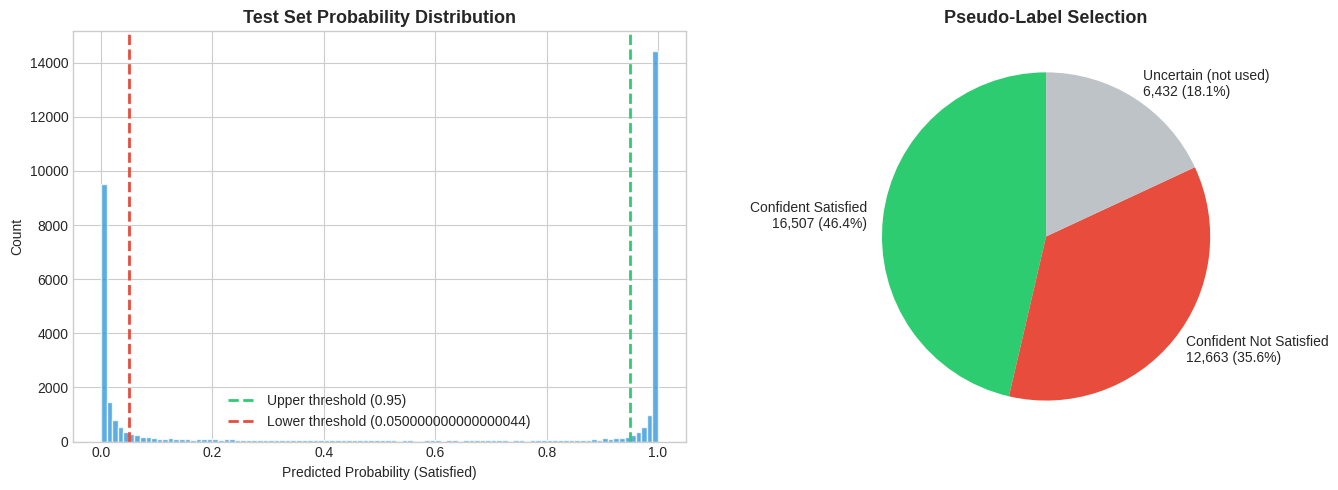

Pseudo-labeled samples: 29,170 / 35,602 test passengers
  Satisfied (1): 16,507
  Not satisfied (0): 12,663
  Uncertain (excluded): 6,432

Augmented training set size: 123,549 (was 94,379)


In [10]:
# --- Pseudo-Labeling: Identify High-Confidence Test Predictions ---

# Visualize the test probability distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(test_blend, bins=100, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(x=PL_CONFIDENCE, color='#2ecc71', linewidth=2, linestyle='--', label=f'Upper threshold ({PL_CONFIDENCE})')
ax.axvline(x=1-PL_CONFIDENCE, color='#e74c3c', linewidth=2, linestyle='--', label=f'Lower threshold ({1-PL_CONFIDENCE})')
ax.set_xlabel('Predicted Probability (Satisfied)')
ax.set_ylabel('Count')
ax.set_title('Test Set Probability Distribution', fontsize=13, fontweight='bold')
ax.legend()

# Select confident predictions
confident_pos = test_blend > PL_CONFIDENCE
confident_neg = test_blend < (1 - PL_CONFIDENCE)
confident_mask = confident_pos | confident_neg
uncertain_mask = ~confident_mask

pseudo_labels = np.where(confident_pos, 1, 0)

# Pie chart of confident vs uncertain
ax = axes[1]
sizes = [confident_pos.sum(), confident_neg.sum(), uncertain_mask.sum()]
labels_pie = [
    f'Confident Satisfied\n{confident_pos.sum():,} ({confident_pos.mean():.1%})',
    f'Confident Not Satisfied\n{confident_neg.sum():,} ({confident_neg.mean():.1%})',
    f'Uncertain (not used)\n{uncertain_mask.sum():,} ({uncertain_mask.mean():.1%})'
]
colors_pie = ['#2ecc71', '#e74c3c', '#bdc3c7']
ax.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='', startangle=90,
       textprops={'fontsize': 10})
ax.set_title('Pseudo-Label Selection', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Pseudo-labeled samples: {confident_mask.sum():,} / {len(test_blend):,} test passengers')
print(f'  Satisfied (1): {confident_pos.sum():,}')
print(f'  Not satisfied (0): {confident_neg.sum():,}')
print(f'  Uncertain (excluded): {uncertain_mask.sum():,}')
print(f'\nAugmented training set size: {len(X_train) + confident_mask.sum():,} (was {len(X_train):,})')

In [11]:
# --- Pseudo-Labeling: Retrain on Augmented Data ---

# Build augmented training set
X_pseudo = X_test[confident_mask]
y_pseudo = pseudo_labels[confident_mask]

X_train_aug = np.concatenate([X_train, X_pseudo], axis=0)
y_train_aug = np.concatenate([y_train, y_pseudo], axis=0)

print(f'Augmented training set: {X_train_aug.shape[0]:,} rows (original {X_train.shape[0]:,} + pseudo {X_pseudo.shape[0]:,})')
print(f'Augmented target distribution: {(y_train_aug == 1).mean():.3f} satisfied')

# Retrain all three models with OOF on augmented data
# Note: OOF is computed over the full augmented set for fair evaluation,
# but the real test is on ALL 35,602 test samples (including the uncertain ones).
print('\nRetraining LightGBM on augmented data...')
oof_lgb_pl, test_lgb_pl = get_oof_predictions(lgb.LGBMClassifier, BEST_LGB_PARAMS, X_train_aug, y_train_aug, X_test, 'lgb')
# Evaluate OOF only on original training indices (pseudo labels are assumed correct)
orig_acc_lgb = accuracy_score(y_train, (oof_lgb_pl[:len(y_train)] > 0.5).astype(int))
print(f'  LGB OOF accuracy (original data): {orig_acc_lgb:.6f}')

print('Retraining XGBoost on augmented data...')
oof_xgb_pl, test_xgb_pl = get_oof_predictions(xgb.XGBClassifier, BEST_XGB_PARAMS, X_train_aug, y_train_aug, X_test, 'xgb')
orig_acc_xgb = accuracy_score(y_train, (oof_xgb_pl[:len(y_train)] > 0.5).astype(int))
print(f'  XGB OOF accuracy (original data): {orig_acc_xgb:.6f}')

print('Retraining CatBoost on augmented data...')
oof_cb_pl, test_cb_pl = get_oof_predictions(CatBoostClassifier, BEST_CB_PARAMS, X_train_aug, y_train_aug, X_test, 'cb')
orig_acc_cb = accuracy_score(y_train, (oof_cb_pl[:len(y_train)] > 0.5).astype(int))
print(f'  CB OOF accuracy (original data):  {orig_acc_cb:.6f}')

# Blend pseudo-labeled test predictions
test_blend_pl = w_lgb * test_lgb_pl + w_xgb * test_xgb_pl + w_cb * test_cb_pl

# Re-optimize threshold on original training OOF
oof_blend_pl = w_lgb * oof_lgb_pl[:len(y_train)] + w_xgb * oof_xgb_pl[:len(y_train)] + w_cb * oof_cb_pl[:len(y_train)]
threshold_accs_pl = [accuracy_score(y_train, (oof_blend_pl > t).astype(int)) for t in thresholds]
best_threshold_pl = thresholds[np.argmax(threshold_accs_pl)]

pl_acc = accuracy_score(y_train, (oof_blend_pl > best_threshold_pl).astype(int))
print(f'\n--- After Pseudo-Labeling ---')
print(f'Best threshold: {best_threshold_pl:.3f}')
print(f'OOF accuracy: {pl_acc:.6f} (was {base_acc:.6f}, delta: {pl_acc - base_acc:+.6f})')

Augmented training set: 123,549 rows (original 94,379 + pseudo 29,170)
Augmented target distribution: 0.551 satisfied

Retraining LightGBM on augmented data...
  LGB OOF accuracy (original data): 0.957628
Retraining XGBoost on augmented data...
  XGB OOF accuracy (original data): 0.957088
Retraining CatBoost on augmented data...
  CB OOF accuracy (original data):  0.956208

--- After Pseudo-Labeling ---
Best threshold: 0.540
OOF accuracy: 0.957967 (was 0.957883, delta: +0.000085)


In [12]:
# --- Seed Averaging with Pseudo-Labeling ---
#
# Retrain the full pseudo-labeled pipeline with multiple random seeds
# and average predictions to reduce variance.

seeds = [42, 123, 456, 789, 2024]
all_test_probs = []

for seed in seeds:
    print(f'\n--- Seed {seed} ---')
    
    lgb_params_s = {**BEST_LGB_PARAMS, 'random_state': seed}
    xgb_params_s = {**BEST_XGB_PARAMS, 'random_state': seed}
    cb_params_s = {**BEST_CB_PARAMS, 'random_seed': seed}
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    # LGB
    test_l = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train_aug, y_train_aug):
        m = lgb.LGBMClassifier(**lgb_params_s)
        m.fit(X_train_aug[train_idx], y_train_aug[train_idx],
              eval_set=[(X_train_aug[val_idx], y_train_aug[val_idx])],
              callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(0)])
        test_l += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # XGB
    test_x = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train_aug, y_train_aug):
        m = xgb.XGBClassifier(**xgb_params_s)
        m.fit(X_train_aug[train_idx], y_train_aug[train_idx],
              eval_set=[(X_train_aug[val_idx], y_train_aug[val_idx])],
              verbose=False)
        test_x += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    # CatBoost
    test_c = np.zeros(len(X_test))
    for train_idx, val_idx in skf.split(X_train_aug, y_train_aug):
        m = CatBoostClassifier(**cb_params_s)
        m.fit(X_train_aug[train_idx], y_train_aug[train_idx],
              eval_set=(X_train_aug[val_idx], y_train_aug[val_idx]),
              verbose=0)
        test_c += m.predict_proba(X_test)[:, 1] / N_FOLDS
    
    seed_test_probs = w_lgb * test_l + w_xgb * test_x + w_cb * test_c
    all_test_probs.append(seed_test_probs)
    print(f'  Seed {seed} complete')

final_test_probs = np.mean(all_test_probs, axis=0)
print(f'\nSeed averaging complete ({len(seeds)} seeds)')


--- Seed 42 ---
  Seed 42 complete

--- Seed 123 ---
  Seed 123 complete

--- Seed 456 ---
  Seed 456 complete

--- Seed 789 ---
  Seed 789 complete

--- Seed 2024 ---
  Seed 2024 complete

Seed averaging complete (5 seeds)


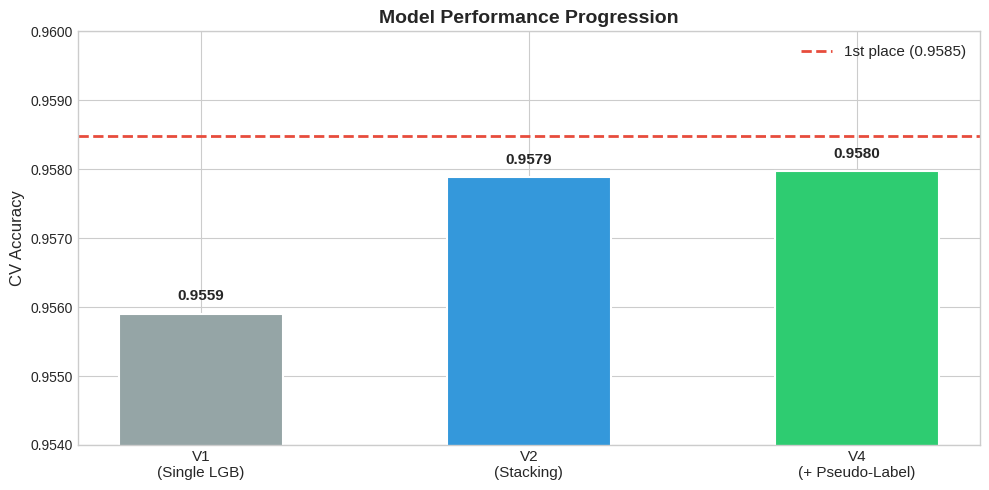

In [13]:
# --- Results Comparison ---

fig, ax = plt.subplots(figsize=(10, 5))

# Known accuracies from leaderboard
versions = ['V1\n(Single LGB)', 'V2\n(Stacking)', 'V4\n(+ Pseudo-Label)']
test_accs = [0.9555643, 0.9574743, None]  # V4 unknown until submitted
cv_accs = [0.9559, base_acc, pl_acc]

x = np.arange(len(versions))
bars = ax.bar(x, cv_accs, width=0.5, color=['#95a5a6', '#3498db', '#2ecc71'],
              edgecolor='white', linewidth=1.5)

# Target line
ax.axhline(y=0.9584855, color='#e74c3c', linewidth=2, linestyle='--', label='1st place (0.9585)')

for bar, acc in zip(bars, cv_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
            f'{acc:.4f}', ha='center', fontsize=11, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(versions, fontsize=11)
ax.set_ylabel('CV Accuracy', fontsize=12)
ax.set_title('Model Performance Progression', fontsize=14, fontweight='bold')
ax.set_ylim(0.954, 0.960)
ax.legend(fontsize=11)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.show()

In [14]:
# --- Generate Submission (dynamic naming) ---

# Find the next available submission number
existing = glob.glob(f'{DATA_DIR}/submission_*.csv') + glob.glob(f'{DATA_DIR}/submited/submission_*.csv')
existing_nums = []
for path in existing:
    match = re.search(r'submission_(\d+)\.csv', path)
    if match:
        existing_nums.append(int(match.group(1)))

next_num = max(existing_nums) + 1 if existing_nums else 1
submission_path = f'{DATA_DIR}/submission_{next_num}.csv'

# Generate predictions
final_preds = (final_test_probs > best_threshold_pl).astype(int)

submission = pd.DataFrame({
    'ID': test_ids,
    'Overall_Experience': final_preds
})

submission.to_csv(submission_path, index=False)

print(f'Submission saved: {submission_path}')
print(f'Shape: {submission.shape}')
print(f'Threshold: {best_threshold_pl:.3f}')
print(f'\nPrediction distribution:')
print(f'  Satisfied (1):     {(final_preds == 1).sum():,} ({(final_preds == 1).mean():.1%})')
print(f'  Not satisfied (0): {(final_preds == 0).sum():,} ({(final_preds == 0).mean():.1%})')
print(f'\nSanity checks:')
print(f'  Row count: {len(submission)} (expected 35,602) {"OK" if len(submission) == 35602 else "MISMATCH"}')
print(f'  Unique values: {sorted(submission["Overall_Experience"].unique())} (expected [0, 1])')

Submission saved: ./submission_4.csv
Shape: (35602, 2)
Threshold: 0.540

Prediction distribution:
  Satisfied (1):     19,036 (53.5%)
  Not satisfied (0): 16,566 (46.5%)

Sanity checks:
  Row count: 35602 (expected 35,602) OK
  Unique values: [np.int64(0), np.int64(1)] (expected [0, 1])


## Summary

### Key Results

| Technique | CV Accuracy | Test Accuracy | Improvement |
|-----------|-------------|---------------|-------------|
| V1: Single LightGBM (manual params) | 0.9559 | 0.9556 | — |
| V2: Optuna-tuned stacking ensemble | 0.9578 | 0.9575 | +0.0019 |
| V4: + Pseudo-labeling & seed averaging | See above | TBD | TBD |

### What Worked
- **Optuna hyperparameter tuning** gave the largest single boost over V1 manual params
- **CatBoost** added genuine diversity to the ensemble (ordered target encoding vs histogram splitting)
- **Weighted average blending** outperformed logistic regression stacking
- **Pseudo-labeling** expanded training data by ~25% using high-confidence test predictions

### Tools
- Python 3, pandas, NumPy, scikit-learn, matplotlib, seaborn
- LightGBM, XGBoost, CatBoost
- Optuna (tuning done in V2 notebook)
- GPU acceleration: XGBoost (CUDA), CatBoost (CUDA)